In [1]:
import pandas as pd
from nltk.corpus import stopwords
from gensim import corpora, models, similarities, utils, matutils

In [2]:
from sklearn import tree, metrics
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [74]:
from libact.base.dataset import Dataset, import_libsvm_sparse
from libact.models import LogisticRegression, SVM, Perceptron
from libact.models import SklearnAdapter
from libact.labelers import IdealLabeler
from libact.query_strategies import RandomSampling, UncertaintySampling,HintSVM, QueryByCommittee

In [3]:
df_all_topics = pd.read_csv('pubmed_data', usecols= ['pid', 'title', 'abstract', 'topic_id', 'sr_title', 'rel'])
df_primary_abstracts = pd.read_csv("primary titles", usecols = ['pid', 'title','abstract'])

In [4]:
df_primary_abstracts.head()

,pid,title,abstract
0,8552821,[Magnetic resonance cholangiopancreatography. ...,Magnetic Resonance cholangiopancreatography (M...
1,2218356,"[Uncomplicated cholelithiasis. Etiology, physi...",NaN
2,22408352,Beneficial effect of sulphate-bicarbonate-calc...,To investigate the effect of drinking sulphate...
3,7965427,Gallbladder sludge in children with sickle cel...,Ultrasonographic records of 75 children with s...
4,9684115,Endoscopic treatment of symptomatic choledocho...,"Today, different endoscopic techniques are ava..."


In [88]:
df_all_topics.head()

,pid,title,abstract,topic_id,sr_title,rel
0,3903849,[Nonvisualization of the gallbladder lumen by ...,Out of 12 000 sonographic examinations of the ...,CD011548,Ultrasound versus liver function tests for dia...,0
1,3903849,[Nonvisualization of the gallbladder lumen by ...,Out of 12 000 sonographic examinations of the ...,CD011549,Endoscopic ultrasound versus magnetic resonanc...,0
2,3903849,[Nonvisualization of the gallbladder lumen by ...,Out of 12 000 sonographic examinations of the ...,CD010339,Endoscopic retrograde cholangiopancreatography...,0
3,1559484,Cholangioscopy.,NaN,CD011548,Ultrasound versus liver function tests for dia...,0
4,1559484,Cholangioscopy.,NaN,CD011549,Endoscopic ultrasound versus magnetic resonanc...,0


In [6]:
df_all_topics.topic_id.value_counts()

CD010409    43335
CD008643    15071
CD009593    14908
CD010339    12803
CD011549    12700
CD011548    12700
CD010783    10905
CD011145    10872
CD008782    10507
CD012019    10317
CD011975     8186
CD011984     8180
CD010653     8002
CD009591     7990
CD009925     6531
CD009579     6455
CD009519     5971
CD010276     5495
CD010173     5495
CD008803     5220
CD008686     3951
CD009323     3855
CD010438     3241
CD008054     3146
CD009647     2785
CD007394     2542
CD009372     2248
CD007431     2074
CD009786     2065
CD011134     1938
CD009551     1911
CD009185     1615
CD009020     1576
CD010633     1573
CD010632     1501
CD007427     1472
CD008691     1310
CD009944     1165
CD010023      981
CD008081      970
CD009135      791
CD010386      625
CD010542      348
CD010771      318
CD010772      316
CD010775      241
CD010896      169
CD010705      114
CD010860       94
CD008760       64
Name: topic_id, dtype: int64

In [7]:
topic_id = 'CD009944'
df_specific_topic = df_all_topics[ df_all_topics['topic_id'] == topic_id]
df_specific_topic.rel.value_counts()

0    1064
1     101
Name: rel, dtype: int64

In [8]:
#primero creamos el diccionario
stop_words = stopwords.words('english')
dictionary = corpora.Dictionary()
for index, row in df_specific_topic.iterrows() :
    if type(row['abstract']) == str:
        title = list(filter(lambda x : x  not in stop_words, utils.tokenize(row['title'], lowercase=True))) 
        abstract = list(filter(lambda x : x  not in stop_words, utils.tokenize(row['abstract'], lowercase=True)))
        dictionary.add_documents([title,abstract]) 

In [9]:
len(dictionary)

6185

In [10]:
labels = []
corpus = []
for index, row in df_specific_topic.iterrows() :
    if type(row['abstract']) == str:
        title = list(filter(lambda x : x  not in stop_words, utils.tokenize(row['title'], lowercase=True))) 
        abstract = list(filter(lambda x : x  not in stop_words, utils.tokenize(row['abstract'], lowercase=True)))
        corpus.append(dictionary.doc2bow(title+abstract))
        labels.append(row['rel'])
        
        

In [11]:
scipy_csc_matrix = matutils.corpus2dense(corpus, 6185)
scipy_csc_matrix_t = scipy_csc_matrix.transpose()
scipy_csc_matrix_t.shape

(984, 6185)

In [13]:
type(scipy_csc_matrix_t)
#scipy_csc_matrix_t.save('./corpus')

numpy.ndarray

In [12]:
clf = BernoulliNB()

scores1 = cross_val_score(clf, scipy_csc_matrix_t, labels, cv=5, scoring=('accuracy')).mean()

print (scores1)

0.887194591727


In [14]:
def split_train_test(X, y, test_size, n_labeled):

    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=test_size)
    trn_ds = Dataset(X_train, np.concatenate(
        [y_train[:n_labeled], [None] * (len(y_train) - n_labeled)]))
    fully_labeled_trn_ds = Dataset(X_train, y_train)

    return trn_ds, X_test, y_test, y_train, fully_labeled_trn_ds

In [15]:
import matplotlib.pyplot as plt
import copy
import numpy as np

In [104]:
def run(trn_ds, X_test, y_test, lbr, model, qs, quota):
    Acurracy_out, F1_macro_out, presicion_out, recall_out  = [], [], [], []

    for _ in range(quota):
        ask_id = qs.make_query()
        X, _ = zip(*trn_ds.data)
        lb = lbr.label(X[ask_id])
        trn_ds.update(ask_id, lb)

        model.train(trn_ds)
        y_pred = model.predict(X_test)
        Acurracy_out = np.append(Acurracy_out, 1 - metrics.accuracy_score(y_test, y_pred))
        F1_macro_out = np.append(F1_macro_out, 1 - metrics.f1_score(y_test, y_pred, average='macro'))
        presicion_out = np.append(presicion_out, 1 - metrics.precision_score(y_test, y_pred, pos_label= 1, average='binary'))
        recall_out = np.append(recall_out, 1 - metrics.recall_score(y_test, y_pred, pos_label=1, average='binary'))
        

    return  Acurracy_out, F1_macro_out, presicion_out, recall_out

In [105]:
test_size = 0.33    # the percentage of samples in the dataset that will be
# randomly selected and assigned to the test set
n_labeled = 10   # number of samples that are initially labeled

# Load dataset
trn_ds, X_test, y_test, y_train, fully_labeled_trn_ds = \
     split_train_test(scipy_csc_matrix_t, labels, test_size, n_labeled)
trn_ds2 = copy.deepcopy(trn_ds)
trn_ds3 = copy.deepcopy(trn_ds)
lbr = IdealLabeler(fully_labeled_trn_ds)

quota = len(y_train) - n_labeled    # number of samples to query


model = LogisticRegression()
qs = RandomSampling(trn_ds)
LgR_Acurracy_out, LgR_F1_macro_out, LgR_presicion_score, LgR_recall_score = \
run(trn_ds, X_test, y_test, lbr, model, qs, quota)

In [106]:
model = LogisticRegression()
qs2 = UncertaintySampling(
         trn_ds2, # Dataset object
         model=LogisticRegression()
     )
LgU_Acurracy_out, LgU_F1_macro_out, LgU_presicion_score_out, LgU_recall_out = \
run(trn_ds2, X_test, y_test, lbr, model, qs2, quota)

In [72]:
model = LogisticRegression()
qs3 = QueryByCommittee(
         trn_ds3, # Dataset object
         models=[
             LogisticRegression(),
             LogisticRegression(C=1.0),
             LogisticRegression(C=0.1),
         ],
     )
BnC_Acurracy_out, BnC_F1_macro_out, BnC_F1_micro_out, BnC_F1_weight_out = \
run(trn_ds3, X_test, y_test, lbr, model, qs3, quota)

There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.


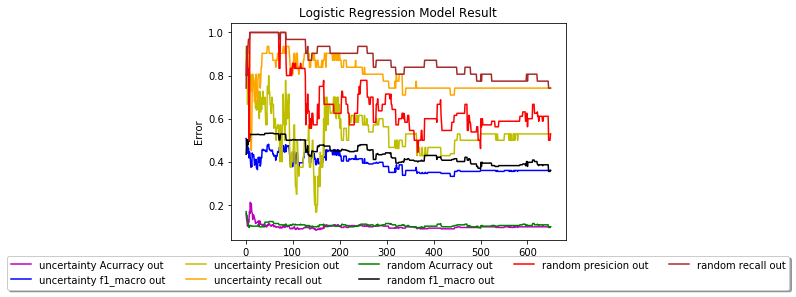

In [109]:
query_num = np.arange(1, quota + 1)
plt.plot(query_num, LgU_Acurracy_out, 'm', label='uncertainty Acurracy out')
plt.plot(query_num, LgU_F1_macro_out, 'blue', label='uncertainty f1_macro out')
plt.plot(query_num, LgU_presicion_score_out, 'y', label='uncertainty Presicion out')
plt.plot(query_num, LgU_recall_out, 'orange', label='uncertainty recall out')
plt.plot(query_num, LgR_Acurracy_out, 'g', label='random Acurracy out')
plt.plot(query_num, LgR_F1_macro_out, 'k', label='random f1_macro out')
plt.plot(query_num, LgR_presicion_score, 'red', label='random presicion out')
plt.plot(query_num, LgR_recall_score, 'brown', label='random recall out')

plt.xlabel('Number of Queries')
plt.ylabel('Error')
plt.title('Logistic Regression Model Result')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=5)
plt.show()

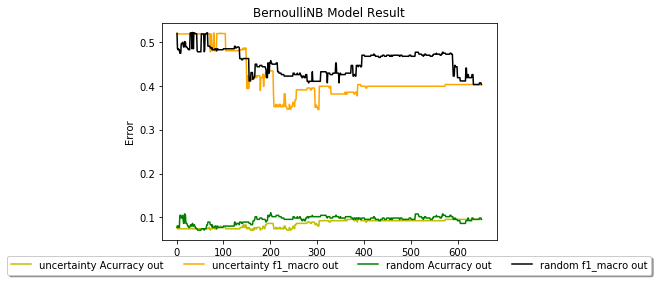

In [46]:
query_num = np.arange(1, quota + 1)
plt.plot(query_num, BnU_Acurracy_out, 'y', label='uncertainty Acurracy out')
plt.plot(query_num, BnU_F1_macro_out, 'orange', label='uncertainty f1_macro out')
plt.plot(query_num, BnR_Acurracy_out, 'g', label='random Acurracy out')
plt.plot(query_num, BnR_F1_macro_out, 'k', label='random f1_macro out')

plt.xlabel('Number of Queries')
plt.ylabel('Error')
plt.title('BernoulliNB Model Result')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=5)
plt.show()

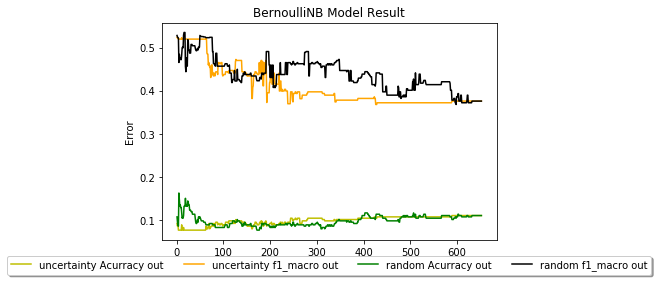

In [27]:
query_num = np.arange(1, quota + 1)
plt.plot(query_num, BnU_Acurracy_out, 'y', label='uncertainty Acurracy out')
plt.plot(query_num, BnU_F1_macro_out, 'orange', label='uncertainty f1_macro out')
plt.plot(query_num, BnR_Acurracy_out, 'g', label='random Acurracy out')
plt.plot(query_num, BnR_F1_macro_out, 'k', label='random f1_macro out')

plt.xlabel('Number of Queries')
plt.ylabel('Error')
plt.title('BernoulliNB Model Result')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=5)
plt.show()

In [85]:
test_size = 0.33    # the percentage of samples in the dataset that will be
# randomly selected and assigned to the test set
n_labeled = 6   # number of samples that are initially labeled

# Load dataset
trn_ds, X_test, y_test, y_train, fully_labeled_trn_ds = \
     split_train_test(scipy_csc_matrix_t, labels, test_size, n_labeled)
trn_ds2 = copy.deepcopy(trn_ds)
trn_ds3 = copy.deepcopy(trn_ds)
lbr = IdealLabeler(fully_labeled_trn_ds)

quota = len(y_train) - n_labeled    # number of samples to query


model = Perceptron()
qs = RandomSampling(trn_ds)
PcR_Acurracy_out, PcR_F1_macro_out, PcR_F1_micro_out, PcR_weight_out = \
run(trn_ds, X_test, y_test, lbr, model, qs, quota)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [86]:
model = Perceptron()
qs3 = QueryByCommittee(
         trn_ds3, # Dataset object
         models=[
             Perceptron(),
             Perceptron(alpha=0.1),
         ],
     )
PcC_Acurracy_out, PcC_F1_macro_out, PcC_F1_micro_out, PcC_F1_weight_out = \
run(trn_ds3, X_test, y_test, lbr, model, qs3, quota)

There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
There is student receiving only one label,re-sample the bag.


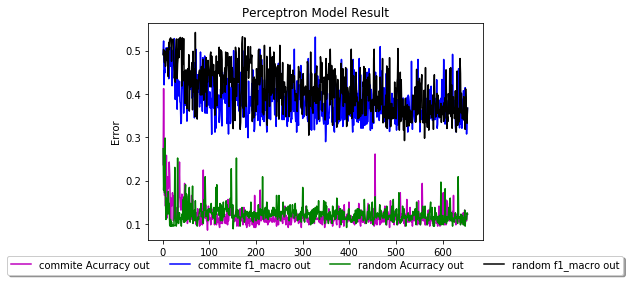

In [89]:
query_num = np.arange(1, quota + 1)
plt.plot(query_num, PcC_Acurracy_out, 'm', label='commite Acurracy out')
plt.plot(query_num, PcC_F1_macro_out, 'blue', label='commite f1_macro out')
#plt.plot(query_num, BnU_Acurracy_out, 'y', label='uncertainty Acurracy out')
#plt.plot(query_num, BnU_F1_macro_out, 'orange', label='uncertainty f1_macro out')
plt.plot(query_num, PcR_Acurracy_out, 'g', label='random Acurracy out')
plt.plot(query_num, PcR_F1_macro_out, 'k', label='random f1_macro out')

plt.xlabel('Number of Queries')
plt.ylabel('Error')
plt.title('Perceptron Model Result')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=5)
plt.show()